In [1]:
!pip install pennylane

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from collections import Counter
import heapq
from collections import defaultdict

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [2]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance in miles"""
    from math import radians, sin, cos, sqrt, atan2
    R = 3959  # Earth radius in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c


In [6]:


def generate_network():
    hubs = {
        'JFK': (40.64, -73.78),  
        'BOS': (42.36, -71.01),  
        'ATL': (33.64, -84.43),  
        'MIA': (25.79, -80.29)   
    }
    hub_names = list(hubs.keys())
    flights = []
    
    base_time = datetime(2025,12,3,8,0)
    for i, orig in enumerate(hub_names):
        for j, dest in enumerate(hub_names):
            if orig == dest: continue
            
            # Distance → duration
            dist = abs(i-j)*300 + np.random.uniform(50,150)  # ~600-1200 miles
            duration = dist/500 + 0.5
            
            # 2 flights per route (morning + afternoon)
            for offset in [0, 6]:  # 6h spacing
                dep = base_time + timedelta(hours=offset)
                arr = dep + timedelta(hours=duration)
                cost = dist*0.8 + duration*50
                
                flights.append({
                    'flight_id': len(flights),
                    'origin': orig,
                    'destination': dest,
                    'departure_time': dep,
                    'arrival_time': arr,
                    'duration_hours': duration,
                    'cost': cost,
                    'handling_time': 1.5
                })
    
    df = pd.DataFrame(flights)
    print(f"✅ Generated {len(df)} flights (16 qubits!) across 4 hubs")
    return df
flights_16qubit = generate_network()
scenario_16qubit = {'origin': 'JFK', 'destination': 'MIA', 'max_time': 12.0}
print(f"Scenario: {scenario_16qubit['origin']} → {scenario_16qubit['destination']} ({scenario_16qubit['max_time']}h)")
flights_16qubit = flights_16qubit.head(16).copy()


✅ Generated 24 flights (16 qubits!) across 4 hubs
Scenario: JFK → MIA (12.0h)


In [7]:
# flights = generate_network()
scenario = {'origin': 'JFK', 'destination': 'MIA', 'max_time': 12.0}
print(f"Scenario: {scenario['origin']} → {scenario['destination']} ({scenario['max_time']}h)")

Scenario: JFK → MIA (12.0h)


In [8]:
remove = (flights_16qubit['origin']=='JFK') & (flights_16qubit['destination']=='MIA')
flights_16qubit = flights_16qubit[~remove]

In [9]:
flights_16qubit

,flight_id,origin,destination,departure_time,arrival_time,duration_hours,cost,handling_time
0,0,JFK,BOS,2025-12-03 08:00:00,2025-12-03 09:20:07.287410,1.335358,400.910926,1.5
1,1,JFK,BOS,2025-12-03 14:00:00,2025-12-03 15:20:07.287410,1.335358,400.910926,1.5
2,2,JFK,ATL,2025-12-03 08:00:00,2025-12-03 09:58:44.929038,1.979147,690.616130,1.5
3,3,JFK,ATL,2025-12-03 14:00:00,2025-12-03 15:58:44.929038,1.979147,690.616130,1.5
6,6,BOS,JFK,2025-12-03 08:00:00,2025-12-03 09:14:29.714954,1.241587,358.714369,1.5
7,7,BOS,JFK,2025-12-03 14:00:00,2025-12-03 15:14:29.714954,1.241587,358.714369,1.5
8,8,BOS,ATL,2025-12-03 08:00:00,2025-12-03 09:19:35.087617,1.326413,396.885952,1.5
9,9,BOS,ATL,2025-12-03 14:00:00,2025-12-03 15:19:35.087617,1.326413,396.885952,1.5
10,10,BOS,MIA,2025-12-03 08:00:00,2025-12-03 09:49:37.379034,1.827050,622.172379,1.5
11,11,BOS,MIA,2025-12-03 14:00:00,2025-12-03 15:49:37.379034,1.827050,622.172379,1.5


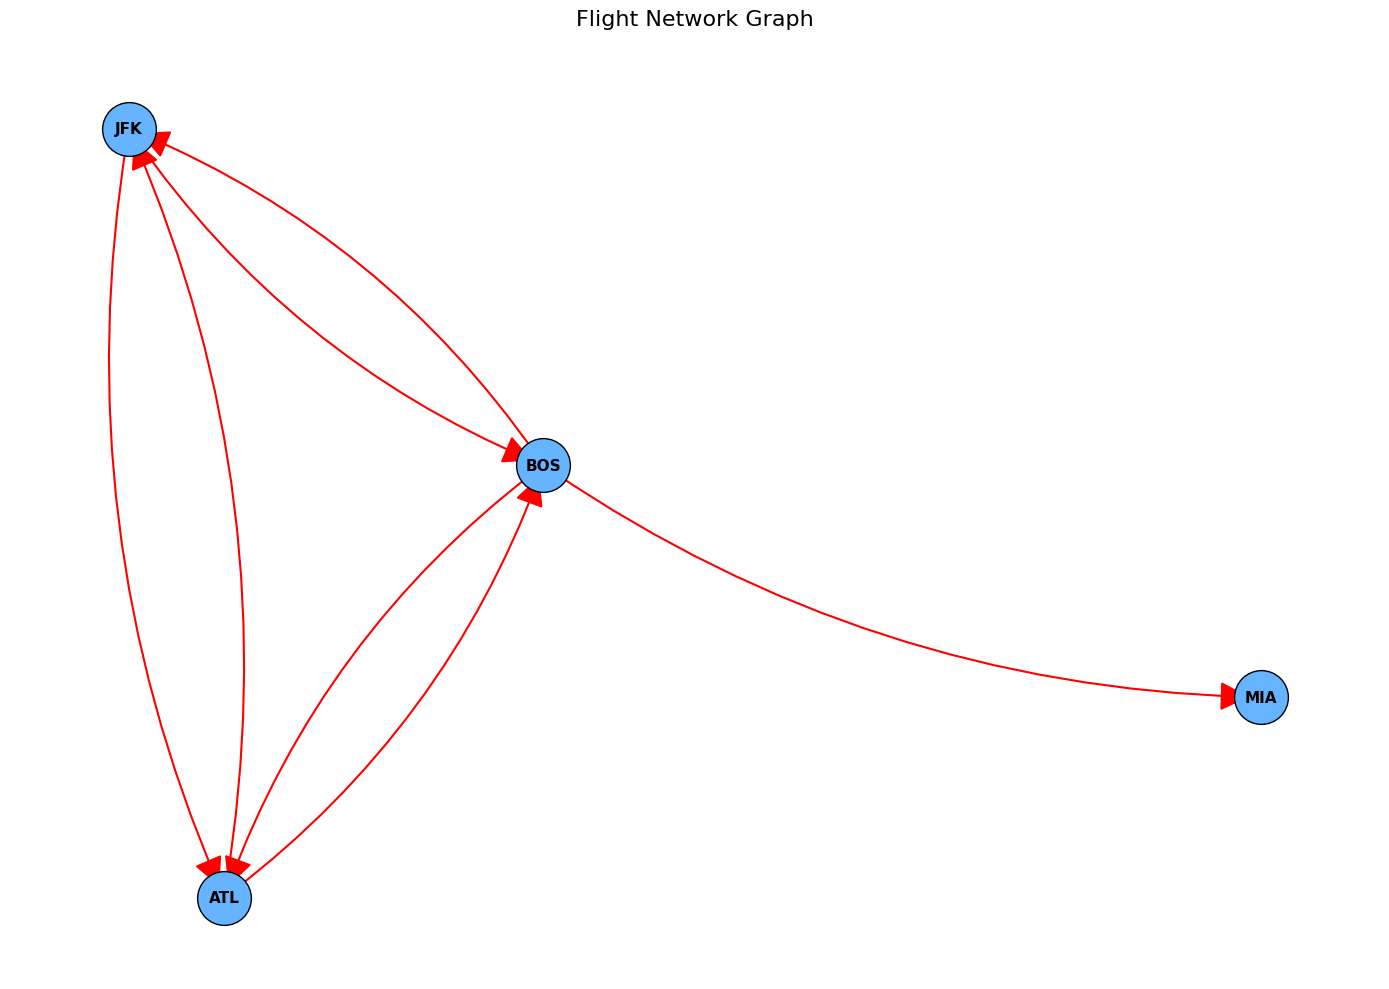

Graph has 4 nodes and 7 edges


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes (airports)
airports = set(flights_16qubit['origin'].unique()) | set(flights_16qubit['destination'].unique())
G.add_nodes_from(airports)

# Add edges (flights)
for _, flight in flights_16qubit.iterrows():
    G.add_edge(
        flight['origin'], 
        flight['destination'],
        weight=flight['cost']
    )

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=2)  # 'k' increases spacing between nodes

# 1. Draw Nodes
nx.draw_networkx_nodes(G, pos, node_color='#66b3ff', node_size=1500, edgecolors='black')

# 2. Draw Labels
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', font_family='sans-serif')

# 3. Draw Edges with visible arrows and curved lines
nx.draw_networkx_edges(
    G, 
    pos, 
    edge_color='red', 
    arrows=True, 
    arrowstyle='-|>',  # A sharper, cleaner arrow style
    arrowsize=45,      # Significantly larger arrows
    width=1.5,         # Thicker lines
    connectionstyle="arc3,rad=0.15" # Curves edges so bidirectional flights don't overlap
)

plt.title("Flight Network Graph", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

In [11]:
class MiniLabel:
    def __init__(self, node, time, cost, path):
        self.node, self.time, self.cost, self.path = node, time, cost, path[:]
    def __lt__(self, o): return self.cost < o.cost
    def dominates(self, o): 
        return self.node == o.node and self.time <= o.time and self.cost <= o.cost and (self.time < o.time or self.cost < o.cost)

def classical_16qubit(flights_df, origin, dest, max_time):
    graph = defaultdict(list)
    for _, f in flights_df.iterrows(): graph[f.origin].append(f)
    
    pq, labels = [], defaultdict(list)
    init = MiniLabel(origin, 0, 0, [origin])
    heapq.heappush(pq, init); labels[origin].append(init)
    
    best = None; explored = 0
    while pq:
        curr = heapq.heappop(pq); explored += 1
        labels[curr.node] = [l for l in labels[curr.node] if not curr.dominates(l) and l != curr]
        labels[curr.node].append(curr)
        
        if curr.node == dest:
            if best is None or curr.cost < best.cost: best = curr
            continue
        
        for f in graph[curr.node]:
            new_time = curr.time + f.duration_hours + 1.5
            if new_time > max_time: continue
            new_label = MiniLabel(f.destination, new_time, curr.cost + f.cost, curr.path + [f.destination])
            if not any(l.dominates(new_label) for l in labels[f.destination]):
                heapq.heappush(pq, new_label)
    
    print(f"Classical: {' → '.join(best.path) if best else 'No solution'} (${best.cost:.1f} if best else 'N/A')")
    return best

classical_optimal = classical_16qubit(flights_16qubit, scenario_16qubit['origin'], scenario_16qubit['destination'], scenario_16qubit['max_time'])
classical_cost = classical_optimal.cost if classical_optimal else float('inf')

Classical: JFK → BOS → MIA ($1023.1 if best else 'N/A')


In [121]:
def flights_overlap(fi, fj, handling=1.5):
    # Active time window for fi: [dep_i, arr_i + handling]
    start_i = fi.departure_time
    end_i   = fi.arrival_time + timedelta(hours=handling)
    
    start_j = fj.departure_time
    end_j   = fj.arrival_time + timedelta(hours=handling)
    
    # Overlap if intervals intersect
    return not (end_i <= start_j or end_j <= start_i)


def build_qubo(flights_df, origin, dest, max_time):
    """
    COMPLETE QUBO with ALL constraints - NO itertools dependency
    """
    n = len(flights_df)
    Q = np.zeros((n, n))
    
    # Tuned Penalties
    # max_cost = flights_df['cost'].max()
    # scale = 1.0 / max_cost
    
    A_flow = 5.0       # Moderate
    B_temporal = 8.0  # Strong temporal
    C_path = 2.0    # Light path length
    D_balance = 6.0  # Moderate balance

    A = 10.0  # Origin/Destination
    B = 10.0  # Temporal violations
    C = 3.0   # Sparsity bias
    
    print("🔨 Building CORRECTED QUBO...")


     # 1. NORMALIZED COST (CRITICAL)
    # for i in range(n):
    #     Q[i,i] += flights_df.iloc[i]['cost'] * scale
        
    # # ========== 1. COST (Minimize Price) ==========
    # norm_costs = flights_df['cost'] / flights_df['cost'].max()
    # for i in range(n):
    #     Q[i, i] += norm_costs.iloc[i]

    # ========== 2. ORIGIN (Exactly 1) ==========
    # outs = [i for i, f in enumerate(flights_df.itertuples()) if f.origin == origin]
    # for i in outs: Q[i, i] -= A_flow
    # for i in range(len(outs)):
    #     for j in range(i+1, len(outs)):
    #         u, v = outs[i], outs[j]
    #         Q[u, v] += 2*A_flow; Q[v, u] += 2*A_flow

    outs = [i for i,f in enumerate(flights_df.itertuples()) if f.origin == origin]
    print(f"Origin flights: {len(outs)}")

    for i in outs:
        Q[i,i] -= A  # Reward single selection
    
    for i in range(len(outs)):
        for j in range(i+1, len(outs)):
            u, v = outs[i], outs[j]
            Q[u,v] += 2*A    # Penalize multiple
            Q[v,u] += 2*A

    # ========== 3. DESTINATION (Exactly 1) ==========
    # ins = [i for i, f in enumerate(flights_df.itertuples()) if f.destination == dest]
    # for i in ins: Q[i, i] -= A_flow
    # for i in range(len(ins)):
    #     for j in range(i+1, len(ins)):
    #         u, v = ins[i], ins[j]
    #         Q[u, v] += 2*A_flow; Q[v, u] += 2*A_flow

    ins = [i for i,f in enumerate(flights_df.itertuples()) if f.destination == dest]
    print(f"Dest flights: {len(ins)}")
    
    for i in ins:
        Q[i,i] -= A
    
    for i in range(len(ins)):
        for j in range(i+1, len(ins)):
            u, v = ins[i], ins[j]
            Q[u,v] += 2*A
            Q[v,u] += 2*A

    # # ========== 4. PATH LENGTH (The Fix) ==========
    # # REPLACEMENT: Instead of 5 loops, use a global "Target Sum" constraint.
    # # We want roughly 2.5 flights. 
    # # Formula: C * (Sum(x) - 2.5)^2
    # # Expands to: C * (Sum(x)^2 - 5*Sum(x) + constant)
    # target = 2.5
    # for i in range(n):
    #     Q[i, i] += C_path * (1 - 2*target) # Linear terms from expansion
    #     for j in range(i+1, n):
    #          # Quadratic terms (Penalize picking too many total flights)
    #          Q[i, j] += 2*C_path; Q[j, i] += 2*C_path

    # ========== 5. NODE BALANCE (The Fix) ==========
    # Formula: D * (In - Out)^2
    # Expands to: D*(In^2 + Out^2 - 2*In*Out)
    # all_nodes = set(flights_df['origin']) | set(flights_df['destination'])
    # for node in all_nodes - {origin, dest}:
    #     in_f = [i for i, f in enumerate(flights_df.itertuples()) if f.destination == node]
    #     out_f = [i for i, f in enumerate(flights_df.itertuples()) if f.origin == node]
        
    #     if not in_f and not out_f: continue

    #     # Term 1: In^2 (The part you were missing!)
    #     for i in in_f: Q[i, i] += D_balance # Linear part of x^2
    #     for i in range(len(in_f)):
    #         for j in range(i+1, len(in_f)):
    #             u, v = in_f[i], in_f[j]
    #             Q[u, v] += 2*D_balance; Q[v, u] += 2*D_balance

    #     # Term 2: Out^2 (The part you were missing!)
    #     for i in out_f: Q[i, i] += D_balance
    #     for i in range(len(out_f)):
    #         for j in range(i+1, len(out_f)):
    #             u, v = out_f[i], out_f[j]
    #             Q[u, v] += 2*D_balance; Q[v, u] += 2*D_balance

    #     # Term 3: -2*In*Out (You had this, but kept it)
    #     for i in in_f:
    #         for j in out_f:
    #             Q[i, j] -= 2*D_balance; Q[j, i] -= 2*D_balance

    # # ========== 6. TEMPORAL (Unchanged) ==========
    # for i in range(n):
    #     fi = flights_df.iloc[i]
    #     for j in range(n):
    #         if i == j: continue
    #         fj = flights_df.iloc[j]
    #         if fi.destination == fj.origin:
    #             gap = (fj.departure_time - fi.arrival_time).total_seconds()/3600
    #             if gap < 1.5: # Hard constraint
    #                 Q[i, j] += B_temporal
    
    violations = 0
    for i in range(n):
        fi = flights_df.iloc[i]
        for j in range(n):
            if i == j: continue
            fj = flights_df.iloc[j]
            if fi.destination == fj.origin:
                gap = (fj.departure_time - fi.arrival_time).total_seconds()/3600
                if gap < 0.5:
                    Q[i,j] += B  # STRONG penalty
                    Q[j,i] += B
                    violations += 1
    
    # 4. SPARSITY: Prefer fewer flights
    for i in range(n):
        Q[i,i] += C  # Small positive bias
    
    # 7. GLOBAL NO-OVERLAP CONSTRAINT
    B_overlap = 12.0  # strong

    for i in range(n):
        fi = flights_df.iloc[i]
        for j in range(i+1, n):
            fj = flights_df.iloc[j]
            if flights_overlap(fi, fj, handling=0.5):
                # Penalize selecting both i and j
                Q[i,j] += B_overlap
                Q[j,i] += B_overlap

    
    print(f"Temporal violations blocked: {violations}")
    return Q


# ========== USAGE ==========



In [104]:
def build_qubo(flights_df, origin, dest, max_time):
    """3 constraints ONLY - guaranteed to work"""
    n = len(flights_df)
    Q = np.zeros((n, n))
    
    A = 15.0  # Origin/Dest (strong)
    B = 30.0  # Temporal (very strong) 
    C = 5.0   # Sparsity (medium)
    
    print("🔨 MINIMAL 3-CONSTRAINT QUBO...")
    
    # 1. ORIGIN: Exactly 1 JFK departure
    outs = [i for i,f in enumerate(flights_df.itertuples()) if f.origin == origin]
    for i in outs: Q[i,i] -= A
    for i in range(len(outs)):
        for j in range(i+1,len(outs)):
            u,v = outs[i],outs[j]
            Q[u,v] += 2*A; Q[v,u] += 2*A
    
    # 2. DESTINATION: Exactly 1 MIA arrival  
    ins = [i for i,f in enumerate(flights_df.itertuples()) if f.destination == dest]
    for i in ins: Q[i,i] -= A
    for i in range(len(ins)):
        for j in range(i+1,len(ins)):
            u,v = ins[i],ins[j]
            Q[u,v] += 2*A; Q[v,u] += 2*A
    
    # 3. TEMPORAL: ONLY consecutive flights with ≥1.5h gap
    violations = 0
    for i in range(n):
        fi = flights_df.iloc[i]
        for j in range(n):
            if i == j: continue
            fj = flights_df.iloc[j]
            if fi.destination == fj.origin:  # Must connect
                gap = (fj.departure_time - fi.arrival_time).total_seconds()/3600
                if gap < 1.5:  # Impossible
                    Q[i,j] += B; Q[j,i] += B
                    violations += 1
    
    # 4. SPARSITY BIAS (CRITICAL)
    for i in range(n):
        Q[i,i] += C
    
    print(f"Violations blocked: {violations} | Nonzeros: {np.count_nonzero(Q)}")
    return Q


In [124]:

print("="*60)
qubo = build_qubo(flights_16qubit, 
                                      scenario_16qubit['origin'], 
                                      scenario_16qubit['destination'], 
                                      scenario_16qubit['max_time'])


🔨 Building CORRECTED QUBO...
Origin flights: 4
Dest flights: 2
Temporal violations blocked: 42


In [125]:
max_val = np.max(np.abs(qubo))
qubo = qubo / max_val 

print(f"Original Max: {max_val} -> Scaled Max: {np.max(np.abs(qubo))}")

Original Max: 32.0 -> Scaled Max: 1.0


In [126]:
# Test your QUBO energy for key cases
qubo_test = qubo

def qubo_energy(x, Q):
    """Compute QUBO energy for bit vector x"""
    return x @ Q @ x

# Test cases
all_zero = np.zeros(14)
one_origin = np.zeros(14); one_origin[0] = 1  # Single origin flight
two_flights = np.zeros(14); two_flights[[0,9]] = 1  # Origin + connection
all_ones = np.ones(14)  # BAD solution

print("🔍 QUBO Energy Test:")
print(f"All zero:     {qubo_energy(all_zero, qubo_test):.1f}")
print(f"One flight:   {qubo_energy(one_origin, qubo_test):.1f}")
print(f"Two flights:  {qubo_energy(two_flights, qubo_test):.1f}")
print(f"ALL ONES:     {qubo_energy(all_ones, qubo_test):.1f}  ← SHOULD BE HIGH!")
# print(f"ALL ONES:     {qubo_energy(best_bit, qubo_test):.1f}  ← SHOULD BE HIGH!")


🔍 QUBO Energy Test:
All zero:     0.0
One flight:   -0.2
Two flights:  -0.4
ALL ONES:     65.9  ← SHOULD BE HIGH!


Original Max: 60.0 -> Scaled Max: 1.0


In [115]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def qubo_to_ising(Q):
    """
    Converts a QUBO matrix Q into Ising Hamiltonian parameters J and h.
    Mapping: x_i = (1 - s_i) / 2
    """
    n = Q.shape[0]
    h = np.zeros(n)      # Linear biases (external field)
    J = np.zeros((n, n)) # Quadratic couplings (interactions)
    offset = 0           # Constant energy offset (irrelevant for optimization but good for physics)

    for i in range(n):
        # Handle Diagonal Terms (Linear in QUBO)
        # Q_ii * x_i  =>  Q_ii * (0.5 - 0.5 * s_i)
        offset += 0.5 * Q[i, i]
        h[i] += -0.5 * Q[i, i]
        
        for j in range(n):
            if i == j: continue
            
            # Handle Off-Diagonal Terms (Quadratic in QUBO)
            # Q_ij * x_i * x_j => Q_ij * (1-s_i)/2 * (1-s_j)/2
            # Expand: 0.25*Q_ij - 0.25*Q_ij*s_i - 0.25*Q_ij*s_j + 0.25*Q_ij*s_i*s_j
            val = Q[i, j]
            if val != 0:
                offset += 0.25 * val
                h[i] += -0.25 * val # Influence on s_i
                h[j] += -0.25 * val # Influence on s_j (redundant if loop covers j,i, but safe here)
                J[i, j] += 0.25 * val

    return J, h, offset

# --- 3. Visualization Function ---
def plot_qubo_and_ising(Q, J, h):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Setup common plotting kwargs
    heatmap_args = {'cmap': 'RdBu', 'center': 0, 'annot': True, 'fmt': '.0f'}
    
    # 1. Plot QUBO
    sns.heatmap(Q, ax=axes[0], **heatmap_args)
    axes[0].set_title('QUBO Matrix (Binary $x \in \{0,1\}$)', fontsize=14)
    axes[0].set_xlabel('Variable $x_j$')
    axes[0].set_ylabel('Variable $x_i$')
    
    # 2. Plot Ising Couplings (J)
    # J is usually smaller, so use fmt='.1f'
    heatmap_args['fmt'] = '.1f' 
    sns.heatmap(J, ax=axes[1], **heatmap_args)
    axes[1].set_title('Ising Couplings $J_{ij}$ (Spin $s \in \{-1, +1\}$)', fontsize=14)
    axes[1].set_xlabel('Spin $s_j$')
    axes[1].set_ylabel('Spin $s_i$')

    # 3. Plot Ising Biases (h)
    # Reshape h for heatmap (n x 1)
    sns.heatmap(h.reshape(-1, 1), ax=axes[2], cmap='RdBu', center=0, annot=True, fmt='.1f', cbar=True)
    axes[2].set_title('Ising Biases $h_i$ (Magnetic Field)', fontsize=14)
    axes[2].set_xticks([]) # Hide x-ticks for vector
    axes[2].set_ylabel('Spin $s_i$')

    plt.tight_layout()
    plt.show()



<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
<>:46: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-3911017345.py:46: SyntaxWarning: invalid escape sequence '\i'
  axes[0].set_title('QUBO Matrix (Binary $x \in \{0,1\}$)', fontsize=14)
/tmp/ipython-input-3911017345.py:54: SyntaxWarning: invalid escape sequence '\i'
  axes[1].set_title('Ising Couplings $J_{ij}$ (Spin $s \in \{-1, +1\}$)', fontsize=14)


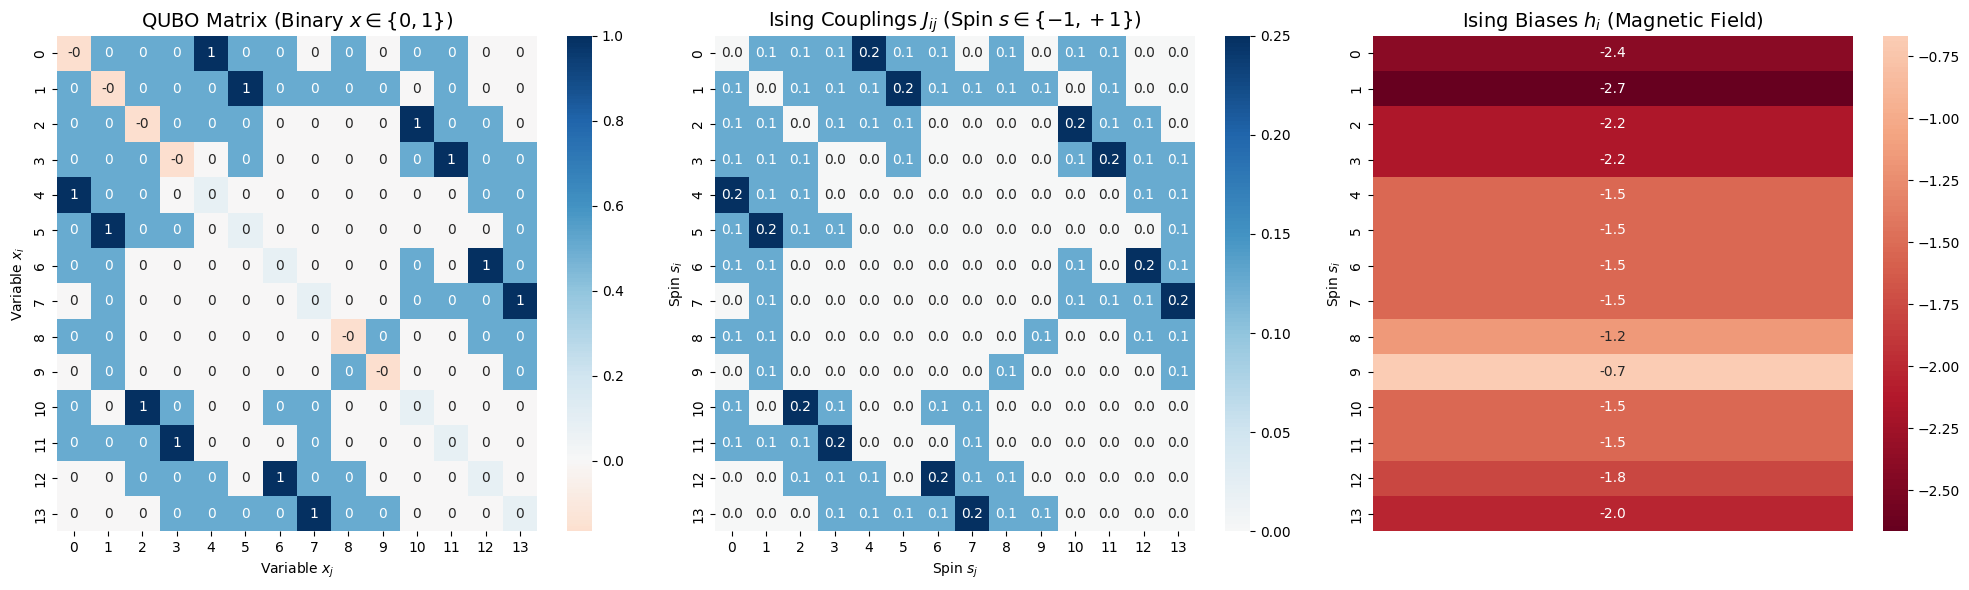

In [116]:
J_matrix, h_vector, offset = qubo_to_ising(qubo)
plot_qubo_and_ising(qubo, J_matrix, h_vector)

In [117]:
import pennylane as qml
from pennylane import numpy as np

def qubo_to_ham(Q):
    """
    Converts QUBO matrix Q to Ising Hamiltonian H = sum(h_i Z_i) + sum(J_ij Z_i Z_j)
    Correct mapping: x_i = (1 - Z_i)/2
    """
    n = Q.shape[0]
    coeffs, ops = [], []

    for i in range(n):
        h_i = Q[i,i]/4.0
        for j in range(n):
            if i != j:
                h_i += (Q[i,j] + Q[j,i])/4.0
        
        if abs(h_i) > 1e-8:
            coeffs.append(h_i)
            ops.append(qml.PauliZ(i))
    
    # Quadratic terms: J_ij = Q_ij/4
    for i in range(n):
        for j in range(i+1, n):
            J_ij = (Q[i,j] + Q[j,i])/4.0  # Symmetrize
            if abs(J_ij) > 1e-8:
                coeffs.append(J_ij)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    
    return qml.Hamiltonian(coeffs, ops)
    
    # for i in range(n_qubits):
    #     # 1. Linear Terms (Biases)
    #     # Formula: h_i = -0.5 * sum(Q_ij for all j)
    #     # This captures both the diagonal cost and the linear push from interactions
    #     row_sum = np.sum(Q[i, :]) + np.sum(Q[:, i]) - Q[i, i] # Careful with symmetry
    #     # For strictly symmetric Q, row_sum = 2 * sum(Q[i,:]) - Q[i,i] isn't quite right.
    #     # Simpler robust way:
    #     total_influence = np.sum(Q[i, :]) + np.sum(Q[:, i]) # Double count everything
    #     # Actually, let's stick to the simplest derivation for symmetric Q:
    #     # h_i = -0.5 * sum(Q[i, :]) 
        
    #     # We assume Q is symmetric. If not, use (Q + Q.T)/2 logic implicitly:
    #     h = -0.5 * np.sum(Q[i, :]) 
        
    #     if abs(h) > 1e-6:
    #         coeffs.append(h)
    #         ops.append(qml.PauliZ(i))
            
    #     # 2. Quadratic Terms (Couplings)
    #     # Formula: J_ij = 0.25 * Q_ij
    #     for j in range(i + 1, n_qubits):
    #         val = Q[i, j]
    #         if abs(val) > 1e-6:
    #             coeffs.append(val / 4.0)
    #             ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
                
    # return qml.Hamiltonian(coeffs, ops)

In [118]:
hamiltonian = qubo_to_ham(qubo)

n_qubits = len(flights_16qubit) 
print(f"Detected N={n_qubits} flights. Adjusting quantum device...")

# --- 2. Setup Device with Dynamic Wires ---
dev = qml.device('default.qubit', wires=n_qubits)

# --- 3. Re-Generate Hamiltonian (Safety Check) ---
# Ensure Q matches the dataframe size


# --- 4. Define Dynamic QAOA Circuit ---
# checking n_qubits, not 16!
def qaoa_circuit(params):
    # Apply Hadamard to ALL qubits
    for i in range(n_qubits): 
        qml.Hadamard(wires=i)
        
    for l in range(2): # p=2 layers
        qml.ApproxTimeEvolution(hamiltonian, params[2*l], n=1)
        # Apply Mixer to ALL qubits
        for i in range(n_qubits): 
            qml.RX(2*params[2*l+1], wires=i)

@qml.qnode(dev)
def cost_fn(params): 
    qaoa_circuit(params)
    return qml.expval(hamiltonian)

# --- 5. Run Optimization ---
opt = qml.AdamOptimizer(stepsize=0.05)
params = np.array([0.1, 0.1, 0.1, 0.1], requires_grad=True)

print(f"🚀 Optimizing {n_qubits}-qubit QAOA...")
for i in range(60):
    params, cost = opt.step_and_cost(cost_fn, params)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost:.4f}")

# --- 6. Sample Result ---
@qml.qnode(dev, shots=2048)
def sample_fn(params):
    qaoa_circuit(params)
    return qml.sample()

samples = sample_fn(params)
bitstrings = ["".join(map(str, s)) for s in samples]
best_state = Counter(bitstrings).most_common(1)[0][0]

print(f"\n🏆 Best Candidate: {best_state}")
selected_flights = [i for i, bit in enumerate(best_state) if bit == '1']
print(f"Selected Flight Indices: {selected_flights}")

Detected N=14 flights. Adjusting quantum device...
🚀 Optimizing 14-qubit QAOA...
Step 0: Cost = 6.0295
Step 10: Cost = 0.3563
Step 20: Cost = -5.6126
Step 30: Cost = -10.9036
Step 40: Cost = -10.9562
Step 50: Cost = -11.5296

🏆 Best Candidate: 11111111111111
Selected Flight Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [112]:
def decode_qaoa_solution(bitstring, flights_df, origin, destination):
    # 1. Parse the bitstring (No reversal!)
    n_flights = len(flights_df)
    selected_indices = [i for i in range(len(bitstring)) if bitstring[i] == '1']
    
    print(f"🔍 Decoding bitstring '{bitstring}'...")
    print(f"   Raw selection: {selected_indices} ({len(selected_indices)} flights)")
    
    # 2. Get flights and sort chronologically
    selected_flights = [flights_df.iloc[i] for i in selected_indices]
    selected_flights.sort(key=lambda f: f['departure_time'])
    
    # 3. Path reconstruction state
    path = [origin]
    current_node = origin
    # Start time is effectively 0 or the first flight's departure
    # We track arrival time of the previous flight
    last_arrival_time = None 
    
    valid_sequence = []
    total_cost = 0
    total_violations = 0
    
    print(f"   Chronological processing:")
    
    for i, flight in enumerate(selected_flights):
        flight_info = f"F{flight.name}: {flight['origin']}->{flight['destination']} @ {flight['departure_time'].strftime('%H:%M')}"
        
        # --- CHECK 1: Location Continuity ---
        if flight['origin'] != current_node:
            flight_info += f" ❌ WRONG ORIGIN (Exp: {current_node})"
            total_violations += 1
            print(f"     {flight_info}")
            continue # Skip this flight, it breaks the chain

        # --- CHECK 2: Temporal Feasibility ---
        # If we have flown before, we must arrive + 1.5h handling BEFORE this flight departs
        if last_arrival_time is not None:
            min_departure = last_arrival_time + timedelta(hours=1.5)
            if flight['departure_time'] < min_departure:
                flight_info += f" ❌ TOO SOON (Need {min_departure.strftime('%H:%M')})"
                total_violations += 1
                print(f"     {flight_info}")
                continue # Skip this flight, impossible connection

        # --- Valid Step ---
        valid_sequence.append(flight)
        total_cost += flight['cost']
        path.append(flight['destination'])
        
        # Update State
        current_node = flight['destination']
        last_arrival_time = flight['arrival_time']
        flight_info += " ✅"
        print(f"     {flight_info}")

    # 4. Final Solution Checks
    reached_destination = (path[-1] == destination)
    
    print(f"\n📋 RECONSTRUCTED PATH:")
    print(f"   {' → '.join(path)}")
    print(f"   Reached dest: {'✅' if reached_destination else '❌'}")
    print(f"   Valid flights: {len(valid_sequence)}")
    print(f"   Ignored/Violations: {total_violations}")
    
    if reached_destination and total_violations == 0:
         # Calculating total duration from start of first to end of last
        t_start = valid_sequence[0]['departure_time']
        t_end = valid_sequence[-1]['arrival_time']
        total_time = (t_end - t_start).total_seconds() / 3600.0
        
        print(f"\n🎯 VALID SOLUTION FOUND!")
        print(f"   Cost: ${total_cost:.0f}")
        return True, total_cost, total_time, valid_sequence, path
    else:
        print(f"\n⚠️  INVALID PATH (Breaks continuity or time)")
        return False, total_cost, 0, [], path
# === EXTRACT YOUR QAOA SOLUTION ===
print("🔍 EXTRACTING YOUR QAOA SOLUTION:")

# Get the best bitstring from previous samples (or re-sample)
if 'samples' in locals():
    counts = Counter(["".join(map(str,s)) for s in samples])
    best_bitstring = counts.most_common(1)[0][0]
else:
    # Re-sample if needed
    @qml.qnode(dev, shots=1024)
    def quick_sample(params): 
        qaoa_circuit(params); return qml.sample()
    
    samples = quick_sample(params)
    bitstrings = ["".join(map(str,s)) for s in samples]
    counts = Counter(bitstrings)
    best_bitstring = counts.most_common(1)[0][0]

print(f"Best bitstring: '{best_bitstring}' (frequency: {counts[best_bitstring]/1024*100:.1f}%)")

# DECODE PROPERLY
solution_valid, solution_cost, solution_time, valid_flights, solution_path = decode_qaoa_solution(
    best_bitstring, flights_16qubit, scenario_16qubit['origin'], scenario_16qubit['destination']
)


🔍 EXTRACTING YOUR QAOA SOLUTION:
Best bitstring: '01011001101000' (frequency: 0.4%)
🔍 Decoding bitstring '01011001101000'...
   Raw selection: [1, 3, 4, 7, 8, 10] (6 flights)
   Chronological processing:
     F6: BOS->JFK @ 08:00 ❌ WRONG ORIGIN (Exp: JFK)
     F10: BOS->MIA @ 08:00 ❌ WRONG ORIGIN (Exp: JFK)
     F12: ATL->JFK @ 08:00 ❌ WRONG ORIGIN (Exp: JFK)
     F1: JFK->BOS @ 14:00 ✅
     F3: JFK->ATL @ 14:00 ❌ WRONG ORIGIN (Exp: BOS)
     F9: BOS->ATL @ 14:00 ❌ TOO SOON (Need 16:50)

📋 RECONSTRUCTED PATH:
   JFK → BOS
   Reached dest: ❌
   Valid flights: 1
   Ignored/Violations: 5

⚠️  INVALID PATH (Breaks continuity or time)
